Leaf Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors

from scipy.stats.stats import pearsonr   

train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

**Data Preparation**

In [2]:
margin_cols = [col for col in train.columns if 'margin' in col]
shape_cols = [col for col in train.columns if 'shape' in col] 
texture_cols = [col for col in train.columns if 'texture' in col] 

In [3]:
label_encoder = LabelEncoder()
classLabel = label_encoder.fit(train.species)
labels = label_encoder.fit_transform(train.species)
classes = list(classLabel.classes_)                    
test_ids = test.id

train_all = train.drop(['species', 'id'], axis=1)
test = test.drop(['id'], axis=1)

scaler = StandardScaler().fit(train_all)
train_all = scaler.transform(train_all)

In [4]:
labels[1]

49

In [5]:
train_margin = train[margin_cols]
train_shape = train[shape_cols]
train_texture = train[texture_cols]
train_margin = train_margin.as_matrix()
train_shape = train_shape.as_matrix()
train_texture = train_texture.as_matrix()

In [6]:
#K-fold with 5  
kfold = KFold(n_splits=5, shuffle=True, random_state=4)

In [7]:
# naive bayse with K-fold cross validation
nb = GaussianNB()
#standardization
#scaler = StandardScaler().fit(train)
#train = scaler.transform(train)
naiveBayseScore = list()
for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    naiveBayse = nb.fit(X_train,y_train)
    naiveBayseScore.append(naiveBayse.score(X_test, y_test))
nb_validation = naiveBayseScore

np.mean(nb_validation)

0.48686868686868684

In [8]:
#linear DiscriminatAnalysis
ld = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')
linearDiscScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    linearDisc = ld.fit(X_train,y_train)
    linearDiscScore.append(linearDisc.score(X_test, y_test))
ld_validation = linearDiscScore

np.mean(ld_validation)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


0.98181818181818181

In [9]:
#KNearestNeighbours
knn = neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance')
kNNScore = list()
for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    KnnCl = knn.fit(X_train,y_train)
    kNNScore.append(KnnCl.score(X_test, y_test))
knn_validation = kNNScore

np.mean(knn_validation)

0.96262626262626261

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import svm
# Binarize the output
labels_class = classLabel.transform(classes)
labels_b = label_binarize(labels, labels_class)
n_classes = labels_b.shape[1]

X_train, X_test, y_train, y_test = train_test_split(train_all, labels_b, test_size=50, random_state=4)
#svc = svm.SVC(kernel='linear', probability=True,random_state=4)
classifier = OneVsRestClassifier(ld)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
#y_score = classifier.fit(X_train, y_train).score(X_test,y_test)
 # Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/anaconda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


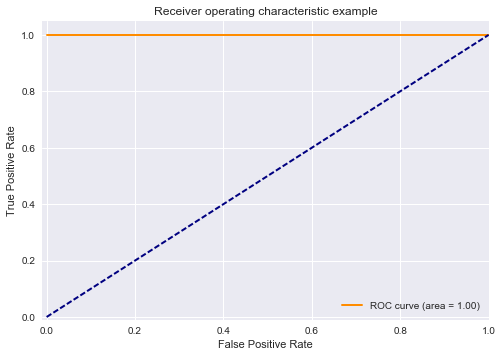

In [11]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

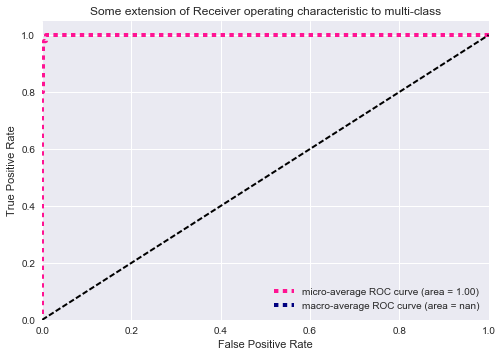

In [12]:
from scipy import interp
from itertools import cycle

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [13]:
#Logistic Regression

logreg = LogisticRegression(solver='lbfgs',multi_class='multinomial')
logregScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    LogReg = logreg.fit(X_train,y_train)
    logregScore.append(LogReg.score(X_test, y_test))
ls_validation = logregScore

np.mean(ls_validation)

0.98181818181818203

In [14]:
#Logistic Regression and a GridSearch

params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs = GridSearchCV(lr, params, scoring=None, refit='True', cv=2) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)


0.98383838383838373

In [ ]:
#random forest
rf = RandomForestClassifier(n_estimators=500)
#random forest
randomForestScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    randomForest = rf.fit(X_train,y_train)
    randomForestScore.append(randomForest.score(X_test, y_test))

rf_validation = randomForestScore

np.mean(rf_validation)

In [15]:
#random forest
etcl = ExtraTreesClassifier(n_estimators=500, random_state=0)
ExtraTreeScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    ExtraTree = etcl.fit(X_train,y_train)
    ExtraTreeScore.append(ExtraTree.score(X_test, y_test))

etcl_validation = ExtraTreeScore

np.mean(etcl_validation)

0.97878787878787887

In [33]:
SvcScore = list()
svc = SVC(kernel="linear")
for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    SvcClass = svc.fit(X_train,y_train)
    SvcScore.append(SvcClass.score(X_test, y_test))

svc_validation = SvcScore

np.mean(svc_validation)

0.98383838383838396

In [34]:
import time

params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs = GridSearchCV(lr, params, scoring=None, refit='True', cv=2) 

exploring_classifiers = {
    'Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto'),
    'K Nearest Neighbors': neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance'),
    'Logistic Regression': GridSearchCV(lr, params, scoring=None, refit='True', cv=2),
    'Spport Vector Machine': SVC(kernel="linear"),
    'random Forest' : ExtraTreesClassifier(n_estimators=500, random_state=0)
}
cls_stats = {}

for cls_name in exploring_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)]}
    cls_stats[cls_name] = stats

# for i in range(2, 10):    
#     kfold = KFold(n_splits= i , shuffle=True, random_state=4)
#     for cls_name, cls in exploring_classifiers.items():
#         #tick = time.time()
#         score = list()
#         for train_index, test_index in kfold.split(train_all): 
#             X_train, X_test = train_all[train_index], train_all[test_index]
#             y_train, y_test = labels[train_index], labels[test_index]
#             cls.fit(X_train, y_train)
#             score.append(cls.score(X_test, y_test))

#         cls_stats[cls_name]['n_train'] = X_train.shape[0]
#         cls_stats[cls_name]['n_train_pos'] = sum(y_train)
#         acc_score = np.mean(score)
#         cls_stats[cls_name]['accuracy'] = acc_score#cls.score(X_test, y_test)
#         acc_history = (cls_stats[cls_name]['accuracy'],cls_stats[cls_name]['n_train'])
#         cls_stats[cls_name]['accuracy_history'].append(acc_history)

from sklearn.model_selection import train_test_split
for i in range(1, 20):
    n = i/20
    X_train, X_test, y_train, y_test = train_test_split(train_all, labels, train_size=n, random_state=4)
    for cls_name, cls in exploring_classifiers.items():
        cls.fit(X_train, y_train)
        cls_stats[cls_name]['n_train'] = X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] = sum(y_train)
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        acc_history = (cls_stats[cls_name]['accuracy'],cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib/python3.6/site-packages/sklearn/covariance/shrunk_covariance_.py:193: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/anaconda/lib/python3.6/site-packages/sklearn/covariance/empirical_covariance_.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib

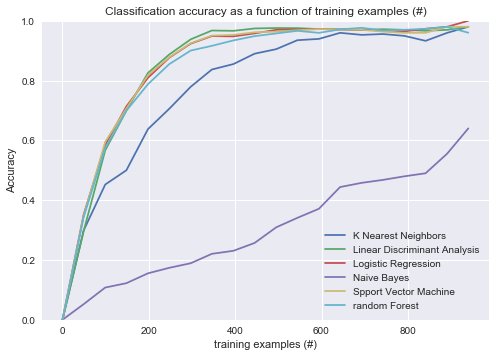

In [35]:
from matplotlib import rcParams

def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)
    
rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
fig = plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0, 1))
plt.legend(cls_names, loc='best')
plt.show()

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
imp_std = np.std([est.feature_importances_ for est in rf.estimators_], axis=0)
fig = plt.figure(figsize=(12, 4))

gs1 = gridspec.GridSpec(1, 2,height_ratios=[1])

ax1, ax2 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])

ax1.margins(0.05), ax2.margins(0.05) 

ax1.bar(range(10), importances[indices][:10], \
       color="#6480e5", yerr=imp_std[indices][:10], ecolor='#31427e', align="center")

ax2.bar(range(10), importances[indices][-10:], \
       color="#e56464", yerr=imp_std[indices][-10:], ecolor='#7e3131', align="center")

ax1.set_xticks(range(10)), ax2.set_xticks(range(10))

ax1.set_xticklabels(indices[:10]), ax2.set_xticklabels(indices[-10:])

ax1.set_xlim([-1, 10]), ax2.set_xlim([-1, 10])
ax1.set_ylim([0, 0.035]), ax2.set_ylim([0, 0.035])

ax1.set_xlabel('Feature numbers'), ax2.set_xlabel('Feature numbers')
ax1.set_ylabel('Random Forest Normalized Importance') 
ax2.set_ylabel('Random Forest Normalized Importance')

ax1.set_title('First 10 Important Features'), ax2.set_title('Last 10 Important Features')
gs1.tight_layout(fig)
plt.show()

In [19]:
#Pearson Coefficient 
#Correlation Analysis
from scipy.stats.stats import pearsonr
#pearsonr(train_margin[3],train_margin[4])
shape_corr_mat=[]
for i in range(len(train_shape[0])-1):
    shape_corr_mat.append([])
    for j in range(len(train_shape[0])-1):
        shape_corr_mat[i].append(pearsonr(train_shape[:,i],train_shape[:,j])[0])

margin_corr_mat=[]
for i in range(len(train_margin[0])-1):
    margin_corr_mat.append([])
    for j in range(len(train_margin[0])-1):
        margin_corr_mat[i].append(pearsonr(train_margin[:,i],train_margin[:,j])[0])
        
texture_corr_mat=[]
for i in range(len(train_texture[0])-1):
    texture_corr_mat.append([])
    for j in range(len(train_texture[0])-1):
        texture_corr_mat[i].append(pearsonr(train_texture[:,i],train_texture[:,j])[0])


In [ ]:
#correlation analysis (TB
fig = plt.figure()
# gs1 = gridspec.GridSpec(1,3) 
# ax1, ax2, ax3 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1]), fig.add_subplot(gs1[2])
# ax1.margins(0.05), ax2.margins(0.05), ax2.margins(0.05)



# MS1= plt.imshow(margin_corr_mat, interpolation='none', cmap=cm.RdYlGn, vmin=-1, vmax=1)
# plt.xlabel('Margin Feature'), plt.ylabel('Margin Feature')
# plt.title('Margin Feature Correlation Matrix')
# cbar = plt.colorbar(MS1, ticks=np.arange(-1.0,1.1,0.2))
# cbar.set_label('Pearson\'s Correlation')

# MS2= plt.imshow(shape_corr_mat, interpolation='none', cmap=cm.RdYlGn, vmin=-1, vmax=1)
# plt.xlabel('Shape Feature'), plt.ylabel('Shape Feature')
# plt.title('Shape Feature Correlation Matrix')
# cbar = plt.colorbar(MS2, ticks=np.arange(-1.0,1.1,0.2))
# cbar.set_label('Pearson\'s Correlation')

MS3= plt.imshow(texture_corr_mat, interpolation='none', cmap=cm.RdYlGn, vmin=-1, vmax=1)
plt.xlabel('Texture Feature'), plt.ylabel('Texture Feature')
plt.title('Texture Feature Correlation Matrix')

cbar = plt.colorbar(MS3, ticks=np.arange(-1.0,1.1,0.2))
cbar.set_label('Pearson\'s Correlation')

plt.show()




In [ ]:
np.var(margin_corr_mat)

**Feature Selection**

Optimal number of features : 138


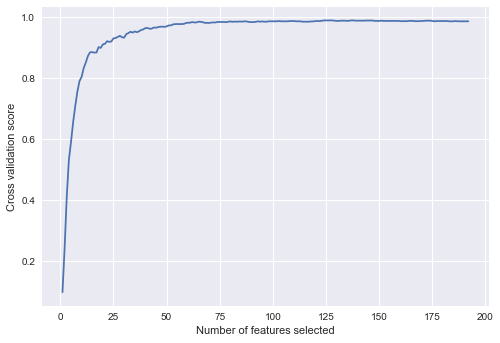

In [55]:
#feature selection exploration

svc = SVC(kernel="linear")
nb = GaussianNB()
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=4, scoring='accuracy')

rfecv = featureSelector.fit(train_all, labels)
train_rfecv = rfecv.transform(train_all) 

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [46]:
import time

params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs = GridSearchCV(lr, params, scoring=None, refit='True', cv=2) 

exploring_classifiers = {
    'Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto'),
    'K Nearest Neighbors': neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance'),
    'Logistic Regression': GridSearchCV(lr, params, scoring=None, refit='True', cv=2),
    'Spport Vector Machine': SVC(kernel="linear"),
    'random Forest' : ExtraTreesClassifier(n_estimators=500, random_state=0)
}
cls_stats = {}

for cls_name in exploring_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)]}
    cls_stats[cls_name] = stats
    
from sklearn.model_selection import train_test_split
for i in range(1, 20):
    n = i/20
    X_train, X_test, y_train, y_test = train_test_split(train_rfecv, labels, train_size=n, random_state=4)
    for cls_name, cls in exploring_classifiers.items():
        cls.fit(X_train, y_train)
        cls_stats[cls_name]['n_train'] = X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] = sum(y_train)
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        acc_history = (cls_stats[cls_name]['accuracy'],cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib/python3.6/site-packages/sklearn/covariance/shrunk_covariance_.py:193: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/anaconda/lib/python3.6/site-packages/sklearn/covariance/empirical_covariance_.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib

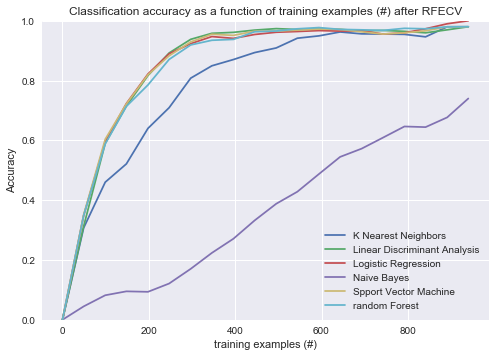

In [48]:
from matplotlib import rcParams

def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s after RFECV' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)
    
rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
fig = plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0, 1))
plt.legend(cls_names, loc='best')
plt.show()

In [ ]:
#selection optimal n number of feature 
svc = SVC(kernel="linear")
rfe = RFE(estimator=svc, n_features_to_select=25, step=1)
train_rfe = rfe.fit_transform(train_all, labels)
train_rfe[1]

In [ ]:
#after RFE
naiveBayseScore = list()
for train_index, test_index in kfold.split(train_rfecv):
    X_train, X_test = train_rfecv[train_index], train_rfecv[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    naiveBayse = nb.fit(X_train,y_train)
    naiveBayseScore.append(naiveBayse.score(X_test, y_test))
nb_validation = naiveBayseScore

np.mean(nb_validation)

**The Classifier Belowed is the best one in my submission at the Kaggle competition** 

In [56]:
#After RFE
#Logistic Regression and a GridSearch
params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr_rfe = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs_rfe = GridSearchCV(lr_rfe, params, scoring=None, refit='True', cv=3) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_rfecv):
    X_train, X_test = train_rfecv[train_index], train_rfecv[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs_rfe.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)

0.98282828282828272

In [72]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import svm
# Binarize the output
labels_class = classLabel.transform(classes)
labels_b = label_binarize(labels, labels_class)
n_classes = labels_b.shape[1]

X_train, X_test, y_train, y_test = train_test_split(train_rfecv, labels_b, test_size=650, random_state=4)
#svc = svm.SVC(kernel='linear', probability=True,random_state=4)
classifier = OneVsRestClassifier(lr_rfe)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
#y_score = classifier.fit(X_train, y_train).score(X_test,y_test)
 # Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

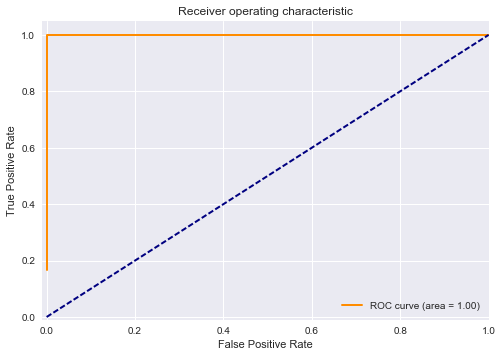

In [74]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**PCA**

In [36]:
#Priciple Component Analysis
pca = PCA(n_components = 'mle', svd_solver = 'full',iterated_power='auto')
pca_fit = pca.fit(train_all)
train_pca=pca_fit.transform(train_all)

In [37]:
import time

params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs = GridSearchCV(lr, params, scoring=None, refit='True', cv=2) 

exploring_classifiers = {
    'Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto'),
    'K Nearest Neighbors': neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance'),
    'Logistic Regression': GridSearchCV(lr, params, scoring=None, refit='True', cv=2),
    'Spport Vector Machine': SVC(kernel="linear"),
    'random Forest' : ExtraTreesClassifier(n_estimators=500, random_state=0)
}
cls_stats = {}

for cls_name in exploring_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)]}
    cls_stats[cls_name] = stats
    
from sklearn.model_selection import train_test_split
for i in range(1, 20):
    n = i/20
    X_train, X_test, y_train, y_test = train_test_split(train_pca, labels, train_size=n, random_state=4)
    for cls_name, cls in exploring_classifiers.items():
        cls.fit(X_train, y_train)
        cls_stats[cls_name]['n_train'] = X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] = sum(y_train)
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        acc_history = (cls_stats[cls_name]['accuracy'],cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib/python3.6/site-packages/sklearn/covariance/shrunk_covariance_.py:193: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/anaconda/lib/python3.6/site-packages/sklearn/covariance/empirical_covariance_.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib

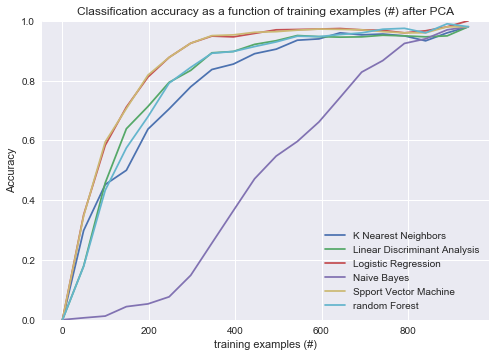

In [38]:
from matplotlib import rcParams

def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s after PCA' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)
    
rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
fig = plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0, 1))
plt.legend(cls_names, loc='best')
plt.show()

In [21]:
#After PCA
nb_pca = GaussianNB()
naiveBayseScore = list()
for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    naiveBayse = nb_pca.fit(X_train,y_train)
    naiveBayseScore.append(naiveBayse.score(X_test, y_test))
    
nb_validation = naiveBayseScore
np.mean(nb_validation)

0.90909090909090895

In [ ]:
#After PCA
#linear DiscriminatAnalysis
#shrinkage='auto',
ld_pca = LinearDiscriminantAnalysis(solver='lsqr')
linearDiscScore = list()

for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    linearDisc = ld_pca.fit(X_train,y_train)
    linearDiscScore.append(linearDisc.score(X_test, y_test))
ld_validation = linearDiscScore

np.mean(ld_validation)

In [ ]:
#After PCA
#KNearestNeighbours
knn_pca = neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance')
kNNScore = list()
for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    KnnCl = knn_pca.fit(X_train,y_train)
    kNNScore.append(KnnCl.score(X_test, y_test))    
knn_validation = kNNScore
np.mean(knn_validation)

**The classifier below perform best in cross validation, but it is not the best fot the test data set**

In [ ]:
#After PCA
#Logistic Regression and a GridSearch
params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr_pca = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs_pca = GridSearchCV(lr_pca, params, scoring=None, refit='True', cv=3) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs_pca.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)

In [ ]:
#After PCA
#random forest
etcl_pca = ExtraTreesClassifier(n_estimators=500, random_state=0)
ExtraTreeScore = list()

for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    ExtraTree = etcl_pca.fit(X_train,y_train)
    ExtraTreeScore.append(ExtraTree.score(X_test, y_test))

etcl_validation = ExtraTreeScore

np.mean(etcl_validation)

In [ ]:
#voting assemble the classifiers
from sklearn.ensemble import VotingClassifier
#('nb_pca',nb_pca), ('ld_pca', ld_pca), ('knn_pca',knn_pca),
eclf1 = VotingClassifier(estimators=[('ld_pca',ld_pca), ('gs_pca', gs_pca)],
                         voting='soft')
VotingClassifierScore = list()
for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    VotingClass = eclf1.fit(X_train,y_train)
    VotingClassifierScore.append(VotingClass.score(X_test, y_test))

np.mean(VotingClassifierScore)

**Separately Train the Classifier Base on different features**
the data has tree different feature, margin, shape and texture. I try to assume that there three kinds of features are independent, and attempt to train them separatly. 

In [ ]:
#Priciple Component Analysis
pca = PCA(n_components = 'mle', svd_solver = 'full',iterated_power='auto')
#pca in margin
pca_margin_fit = pca.fit(train_margin)
train_margin_pca=pca_margin_fit.transform(train_margin)
#pca in shape
pca_shape_fit = pca.fit(train_shape)
train_shape_pca = pca_shape_fit.transform(train_shape)
#pca in texture
pca_texture_fit = pca.fit(train_texture)
train_texture_pca = pca_shape_fit.transform(train_texture)


In [ ]:
#feature selection exploration
svc = SVC(kernel="linear")
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')

rfecv = featureSelector.fit(train_margin, labels)
train_margin_rfecv = rfecv.transform(train_margin) 

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [ ]:
#feature selection exploration
svc = SVC(kernel="linear")
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')

rfecv = featureSelector.fit(train_shape, labels)
train_shape_rfecv = rfecv.transform(train_shape)

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [ ]:
#feature selection exploration
svc = SVC(kernel="linear")
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')

rfecv = featureSelector.fit(train_texture, labels)
train_texture_rfecv = rfecv.transform(train_texture) 

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [ ]:
train_two = np.concatenate((train_margin_pca, train_texture_pca),axis = 1)

In [53]:
params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr_pca = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs_pca = GridSearchCV(lr_pca, params, scoring=None, refit='True', cv=3) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_texture):
    X_train, X_test = train_texture[train_index], train_texture[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs_pca.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)

0.76161616161616164

In [ ]:
#After PCA
#KNearestNeighbours
knn_pca = neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance')
kNNScore = list()
for train_index, test_index in kfold.split(train_texture_pca):
    X_train, X_test = train_texture_pca[train_index], train_texture_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    KnnCl = knn_pca.fit(X_train,y_train)
    kNNScore.append(KnnCl.score(X_test, y_test))    
knn_validation = kNNScore
np.mean(knn_validation)

**Test the data in test set**

In [ ]:
test = scaler.transform(test)
test_rfe= rfecv.transform(test)
test_predictions = eclf1.predict_proba(test_pca)

log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

test_predictions = eclf1.predict(test)

acc = accuracy_score(, test_predictions)

acc

In [ ]:
len(train_rfecv[0])
len(test[0])

In [ ]:
test = scaler.transform(test)
test_rfe = rfecv.transform(test)
test_predictions = gs_rfe.predict_proba(test_rfe)

submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()
submission.set_index('id', inplace=True)
fp = open('submit.csv', 'w')
fp.write(submission.to_csv())
print('Finished writing submission')
submission.tail()